##### Copyright 2019 Qiyang Hu

In [0]:
#@title Licensed under MIT License (the "License")
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/idre_learning_machine_learning/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

The major content in this notebook about the mobile net and the CNN model is mainly adopted and based from Google's Udacity [Course](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c01_tensorflow_hub_and_transfer_learning.ipynb).

# Importing Packages

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
#!pip install "tensorflow_hub>=0.6.0"

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
from shutil import copyfile
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Use  a TensorFlow Hub MobileNet for prediction

In [0]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

286720/281899 [==============================] - 0s 0us/step


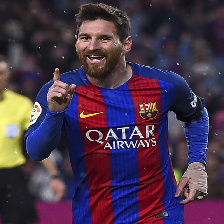

In [0]:
person_pic_url = "https://www.biography.com/.image/t_share/MTQ4MDU5NDU0MzgwNzEzNDk0/lionel_messi_photo_josep_lago_afp_getty_images_664928892_resizedjpg.jpg"
person = tf.keras.utils.get_file('person4.jpg',person_pic_url)
person = Image.open(person).resize((IMAGE_RES, IMAGE_RES))
person

In [0]:
person = np.array(person)/255.0
person.shape

(224, 224, 3)

In [0]:
result = model.predict(person[np.newaxis, ...])
result.shape

(1, 1001)

In [0]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

982

16384/10484 [==============================================] - 0s 0us/step


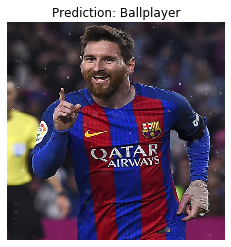

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(person)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

253952/249726 [==============================] - 0s 1us/step


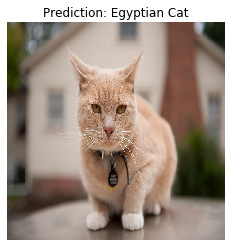

In [0]:
pic_url = "https://www.nationalgeographic.com/content/dam/news/2018/05/17/you-can-train-your-cat/02-cat-training-NationalGeographic_1484324.jpg"
pic = tf.keras.utils.get_file('pic1.jpg',pic_url)
pic = Image.open(pic).resize((IMAGE_RES, IMAGE_RES))
pic = np.array(pic)/255.0

result = model.predict(pic[np.newaxis, ...])

predicted_class = np.argmax(result[0], axis=-1)
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(pic)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Use a TensorFlow Hub models for the Dogs vs. Cats dataset

## Mounting Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Download Data from Kaggle

In [0]:
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!kaggle competitions list -s dogs-vs-cats

ref                                 deadline             category       reward  teamCount  userHasEntered  
----------------------------------  -------------------  ----------  ---------  ---------  --------------  
dogs-vs-cats                        2014-02-01 23:59:00  Playground       Swag        215            True  
dogs-vs-cats-redux-kernels-edition  2017-03-02 23:59:00  Playground  Knowledge       1314            True  


In [0]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content

 95% 259M/271M [00:06<00:00, 31.3MB/s]
100% 271M/271M [00:06<00:00, 46.4MB/s]
 99% 537M/544M [00:19<00:00, 25.8MB/s]
100% 544M/544M [00:19<00:00, 29.3MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 106MB/s]


In [0]:
zip_train_dir = tf.keras.utils.get_file('train.zip', origin='file:///content/train.zip', extract=True)
zip_test_dir = tf.keras.utils.get_file('test.zip', origin='file:///content/test.zip', extract=True)

284483584/284478493 [==============================] - 1s 0us/step


#### Using Keras's `flow_from_directory`

![alt text](https://miro.medium.com/max/1400/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

In [0]:
train_orig_dir = os.path.join(os.path.dirname(zip_train_dir), 'train')
base_dir = "/content"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [0]:
os.makedirs(train_cats_dir)
os.makedirs(train_dogs_dir)
os.makedirs(validation_cats_dir)
os.makedirs(validation_dogs_dir)

In [0]:
filenames = os.listdir(train_orig_dir)
min_index_validation = int(len(filenames)/3) # using 1/3 of training data as validation data
for filename in filenames:
    src = os.path.join(train_orig_dir, filename)
    category = filename.split('.')[0]
    imageId  = filename.split('.')[1]
    extension = filename.split('.')[2]
    if category == 'dog':
        if int(imageId) < min_index_validation:
            dst = os.path.join(train_dogs_dir, imageId+'.'+extension)
        else:
            dst = os.path.join(validation_dogs_dir, imageId+'.'+extension)
    else:
        if int(imageId) < min_index_validation:
            dst = os.path.join(train_cats_dir, imageId+'.'+extension)
        else:
            dst = os.path.join(validation_cats_dir, imageId+'.'+extension)
    copyfile(src, dst)

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [0]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 8333
total training dog images: 8333
total validation cat images: 4167
total validation dog images: 4167
--
Total training images: 16666
Total validation images: 8334


# Data without Augmentation

In [0]:
BATCH_SIZE = 32  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 224  # Our training data consists of images with width of 224 pixels and height of 224 pixels

In [0]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(224,224)
                                                           class_mode='binary')

Found 16666 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(224,224)
                                                              class_mode='binary')

Found 8334 images belonging to 2 classes.


In [0]:
sample_training_images, _ = next(train_data_gen) 

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

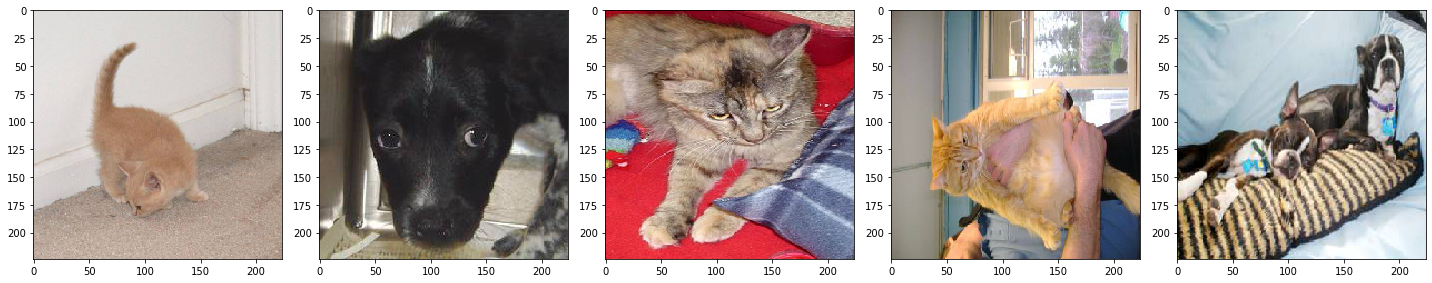

In [0]:
plotImages(sample_training_images[:5])  # Plot images 0-4

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

In [0]:
for image_batch, label_batch in train_data_gen:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32,)


In [0]:
result_batch = model.predict(image_batch)
result_batch.shape

(32, 1001)

## Do simple transfer learning with TensorFlow Hub

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
IMAGE_RES = 224
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [0]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor.trainable = False

### Define a model

In [0]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Compile and train the model

In [0]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 5
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
                             )

Epoch 1/5
521/521 [==============================] - 131s 252ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 0.0849 - val_accuracy: 0.9812
Epoch 2/5
521/521 [==============================] - 131s 251ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0949 - val_accuracy: 0.9778
Epoch 3/5
521/521 [==============================] - 131s 251ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0836 - val_accuracy: 0.9814
Epoch 4/5
521/521 [==============================] - 131s 251ms/step - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.0823 - val_accuracy: 0.9827
Epoch 5/5
521/521 [==============================] - 130s 250ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0862 - val_accuracy: 0.9800


### Visualizing results of the training

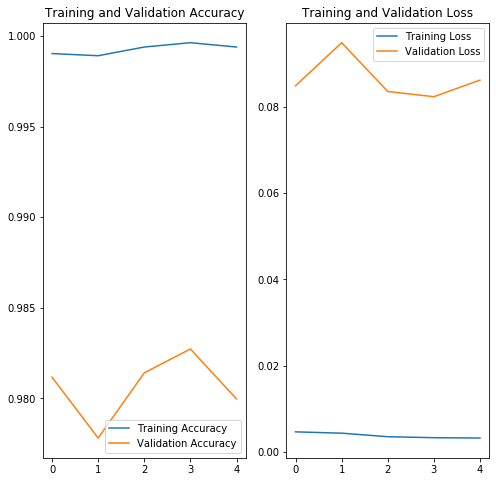

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

### Save the model

In [0]:
t = time.time()
savedmodel_dir = "/content/drive/My Drive/saved_model/dogcats/{}".format(int(t))
print(savedmodel_dir)

/content/drive/My Drive/saved_model/dogcats/1573672873


In [0]:
model.save(savedmodel_dir) 

In [0]:
os.listdir(savedmodel_dir)

['variables', 'assets', 'saved_model.pb']

### Load the model

In [0]:
# load the model saved before
t = 1573672873
savedmodel_dir = "/content/drive/My Drive/saved_model/dogcats/{}".format(int(t))
new_model = tf.keras.models.load_model(savedmodel_dir)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              1280      
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 3,842
Trainable params: 2,562
Non-trainable params: 1,280
_________________________________________________________________


### Keep training if not finished

In [0]:
epochs=1
history = new_model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

### Predict the model

#### Prepare Testing Data

In [0]:
test_orig_dir = os.path.join(os.path.dirname(zip_test_dir), 'test')
base_dir = "/content"
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir)

filenames = os.listdir(test_orig_dir)
for filename in filenames:
    src = os.path.join(test_orig_dir, filename)
    dst = os.path.join(test_dir, filename)
    copyfile(src, dst)
    
test_filenames = os.listdir(test_dir)
nb_samples = len(filenames)
    
print("Total test images:", nb_samples)

Total test images: 12500


In [0]:
ids = []
for fullfilename in test_filenames:
    filename = os.path.basename(fullfilename)
    ids.append(os.path.splitext(filename)[0])

#### Using `flow_from_dataframe` method

In [0]:
test_df = pd.DataFrame({
    'filename': test_filenames,
    'id': ids
})
nb_samples = test_df.shape[0]
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_dir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    batch_size=1,
    shuffle=False
)

Found 12500 validated image filenames.


#### Predict

In [0]:
predict = model.predict_generator(test_generator, steps=nb_samples)

In [0]:
test_df['label'] = predict[:,1]
test_df.head()

,filename,id,label
0,1545.jpg,1545,2.527340e-03
1,8003.jpg,8003,1.000000e+00
2,5987.jpg,5987,1.875060e-12
3,3069.jpg,3069,4.662960e-01
4,10445.jpg,10445,9.999722e-01


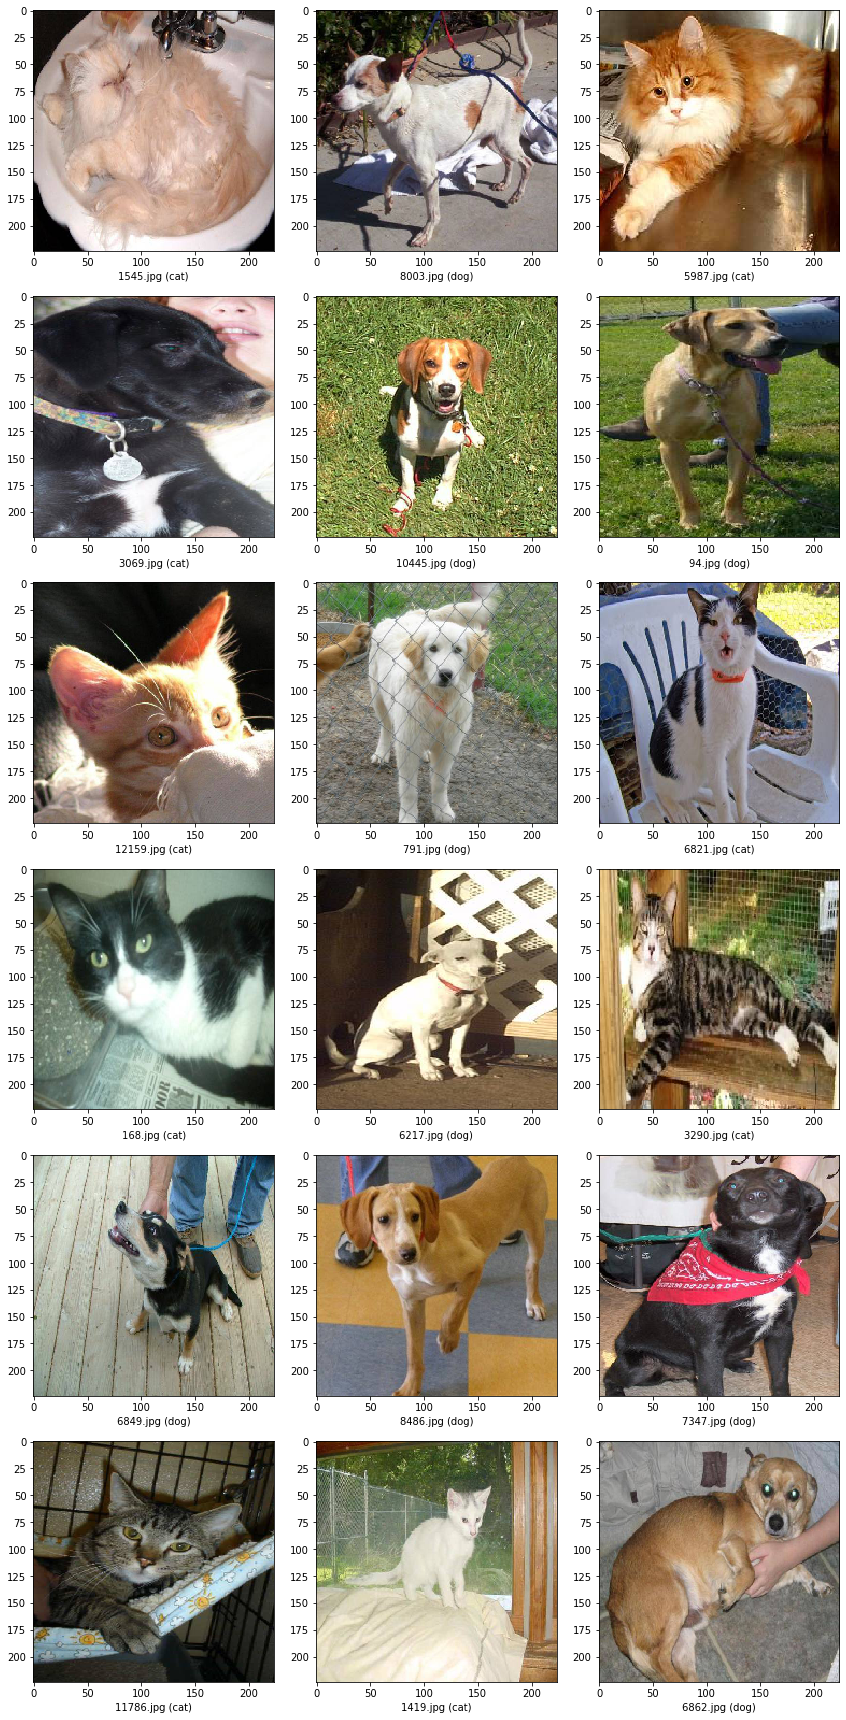

In [0]:
sample_test = test_df.head(18)
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    id = row['id']
    category = "dog" if row['label'] >= 0.5 else "cat"
    img = load_img('test/'+filename, target_size=(IMG_SHAPE,IMG_SHAPE))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(id + '.jpg (' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

### Submission to Kaggle

In [0]:
test_df[['id','label']].to_csv('mobilenet_03.csv', index=False)

In [0]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f mobilenet_02.csv -m "My third submission with mobilenet"

100% 206k/206k [00:00<00:00, 668kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition